In [ ]:
import sys
from neurodsp.sim import set_random_seed
from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.utils import create_times
from neurodsp.plts import plot_timefrequency#

import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

set_random_seed(84)

from pyrasa.irasa import irasa_sprint

In [12]:
# Set some general settings, to be used across all simulations
fs = 500
n_seconds = 15
duration=4
overlap=0.5

# Create a times vector for the simulations
times = create_times(n_seconds, fs)


alpha = sim_oscillation(n_seconds=.5, fs=fs, freq=10)
no_alpha = np.zeros(len(alpha))
beta = sim_oscillation(n_seconds=.5, fs=fs, freq=25)
no_beta = np.zeros(len(beta))

exp_1 = sim_powerlaw(n_seconds=2.5, fs=fs, exponent=-1)
exp_2 = sim_powerlaw(n_seconds=2.5, fs=fs, exponent=-2)


alphas = np.concatenate([no_alpha, alpha, no_alpha, alpha, no_alpha])
betas = np.concatenate([beta, no_beta, beta, no_beta, beta])

sim_ts = np.concatenate([exp_1 + alphas, 
                         exp_1 + alphas + betas, 
                         exp_1 + betas, 
                         exp_2 + alphas, 
                         exp_2 + alphas + betas, 
                         exp_2 + betas, ])

In [13]:
freqs = np.arange(1, 50, 0.5)
import scipy.signal as dsp

# mwt = compute_wavelet_transform(sim_ts, fs=fs, 
#                                 freqs=freqs, n_cycles=11,
#                                 )

irasa_sprint_spectrum = irasa_sprint(sim_ts, fs=fs,
                                                       band=(1, 50),
                                                       overlap_fraction=.95,
                                                       win_duration=.5,
                                                       hset_info=(1.05, 4., 0.05),
                                                       win_func=dsp.windows.hann)

Lets check whats stored in the IrasaTfSpectrum returned by irasa_sprint

In [14]:
print(irasa_sprint_spectrum)

IrasaTfSpectrum Summary
------------------------
Channels      : 1 unnamed channel
Frequency (Hz): 2.44–49.80 Hz, Δf ≈ 0.49 Hz
Time (s)      : 0.00–14.98 s, Δt ≈ 0.02 s
Attributes    : raw_spectrum, aperiodic, periodic, freqs, ch_names, time
Methods       : fit_aperiodic_model(), get_peaks(), get_aperiodic_error()



In [15]:
irasa_sprint_spectrum.ch_names

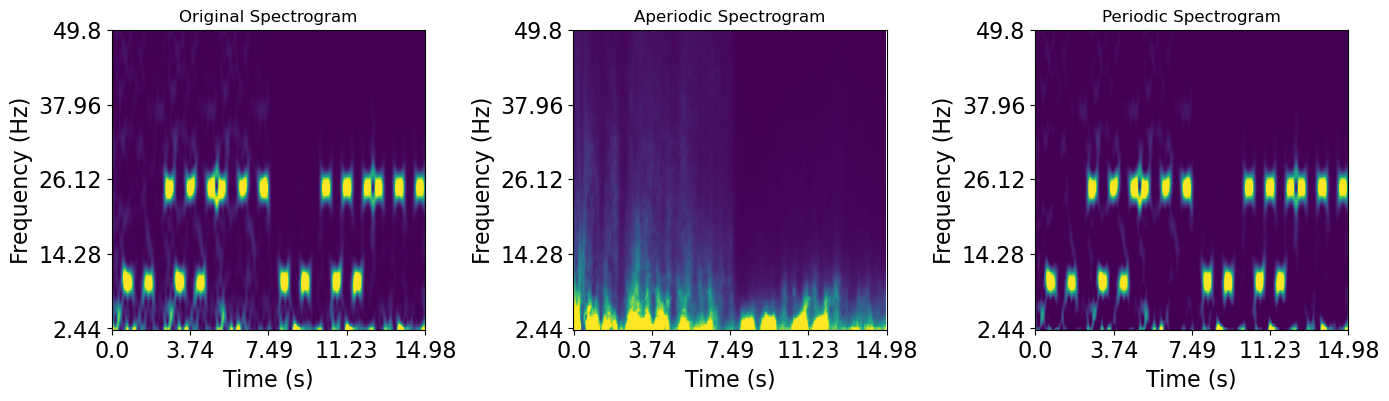

In [19]:
#%%
f, axes = plt.subplots(figsize=(14, 4), ncols=3)
plot_timefrequency(irasa_sprint_spectrum.time, irasa_sprint_spectrum.freqs, np.squeeze(irasa_sprint_spectrum.raw_spectrum), vmin=0, vmax=0.1, ax=axes[0])
plot_timefrequency(irasa_sprint_spectrum.time, irasa_sprint_spectrum.freqs, np.squeeze(irasa_sprint_spectrum.aperiodic), vmin=0, vmax=0.02, ax=axes[1])
plot_timefrequency(irasa_sprint_spectrum.time, irasa_sprint_spectrum.freqs, np.squeeze(irasa_sprint_spectrum.periodic), vmin=0, vmax=0.1, ax=axes[2])

for ax, title in zip(axes, ['Original Spectrogram', 'Aperiodic Spectrogram', 'Periodic Spectrogram',]):
    ax.set_title(title)

In [20]:
ap_spec = irasa_sprint_spectrum.fit_aperiodic_model()

In [21]:
ap_spec.gof

,mse,R2,R2_adj.,BIC,BIC_adj.,AIC,fit_type,ch_name,time
0,0.015514,0.953981,0.953012,-9.931150,-16.246852,-15.101085,fixed,0,0.000
0,0.012203,0.960979,0.960157,-11.031624,-17.347327,-16.201559,fixed,0,0.024
0,0.008988,0.968400,0.967735,-12.433772,-18.749474,-17.603707,fixed,0,0.048
0,0.006437,0.974351,0.973811,-13.964397,-20.280099,-19.134332,fixed,0,0.072
0,0.004351,0.980156,0.979738,-15.760302,-22.076004,-20.930237,fixed,0,0.096
...,...,...,...,...,...,...,...,...,...
0,0.008244,0.980839,0.980435,-12.829907,-19.145609,-17.999842,fixed,0,14.880
0,0.008216,0.980993,0.980593,-12.845634,-19.161336,-18.015569,fixed,0,14.904
0,0.008778,0.979619,0.979190,-12.542240,-18.857942,-17.712175,fixed,0,14.928
0,0.008554,0.979376,0.978942,-12.660913,-18.976615,-17.830848,fixed,0,14.952


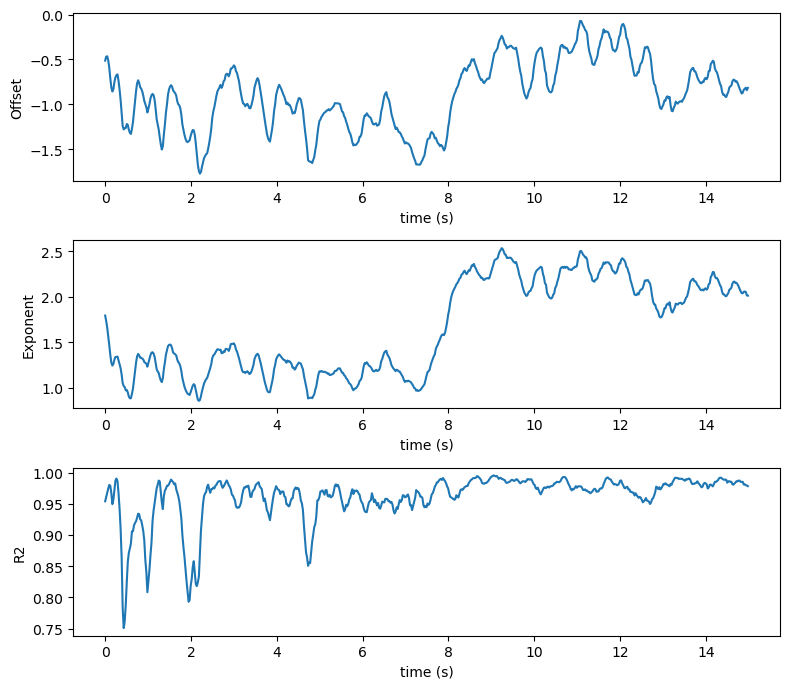

In [22]:
f, ax = plt.subplots(nrows=3, figsize=(8, 7))

ax[0].plot(ap_spec.aperiodic_params['time'], ap_spec.aperiodic_params['Offset'])
ax[0].set_ylabel('Offset')
ax[0].set_xlabel('time (s)')
ax[1].plot(ap_spec.aperiodic_params['time'], ap_spec.aperiodic_params['Exponent'])
ax[1].set_ylabel('Exponent')
ax[1].set_xlabel('time (s)')
ax[2].plot(ap_spec.aperiodic_params['time'], ap_spec.gof['R2'])
ax[2].set_ylabel('R2')
ax[2].set_xlabel('time (s)')

f.tight_layout()

In [23]:
peaks_spec = irasa_sprint_spectrum.get_peaks(cut_spectrum=(1, 40),
                                  smooth=True,
                                  smoothing_window=1,
                                  peak_threshold=2,
                                  min_peak_height=0.01,
                                  peak_width_limits=(0.5, 12))

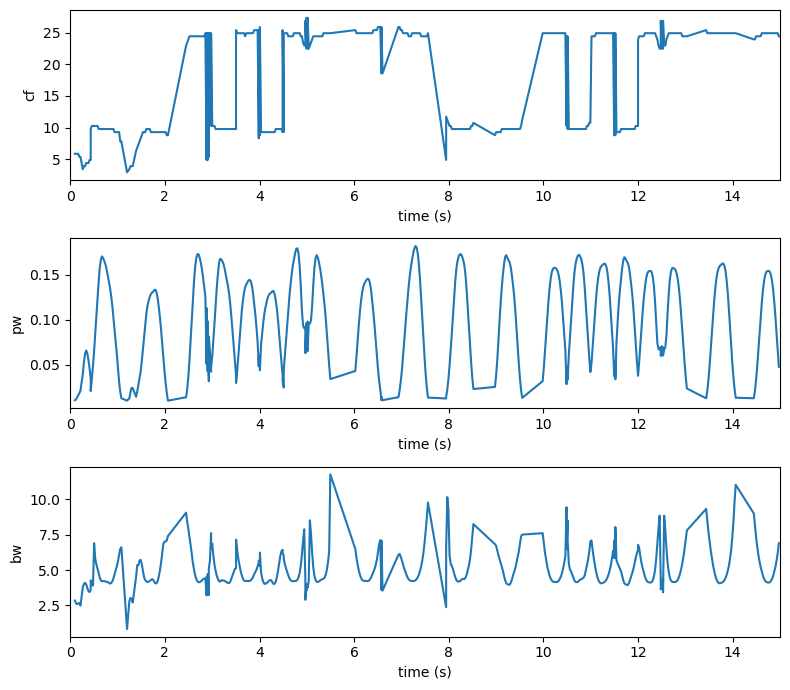

In [24]:
f, ax = plt.subplots(nrows=3, figsize=(8, 7))

for ix, cur_key in enumerate(['cf', 'pw', 'bw']):

    ax[ix].plot(peaks_spec['time'], peaks_spec[cur_key])
    ax[ix].set_ylabel(cur_key)
    ax[ix].set_xlabel('time (s)')
    ax[ix].set_xlim(0, 15)

f.tight_layout()

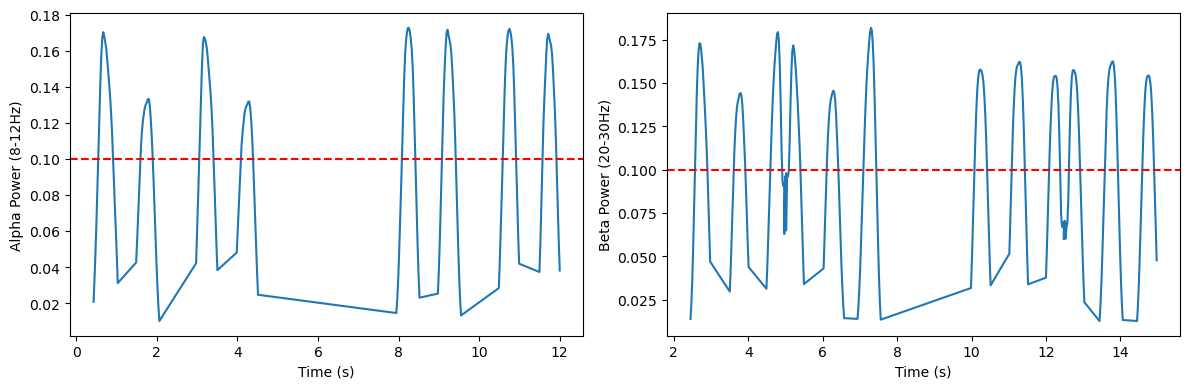

In [25]:
from pyrasa.utils.peak_utils import get_band_info

df_alpha = get_band_info(peaks_spec, freq_range=(8,12), ch_names=[])
alpha_peaks = df_alpha.query('pw > 0.10')

beta_ts = alpha_peaks['time'].to_numpy()
t1 = beta_ts[0]
n_peaks = 0
for ix, i in enumerate(beta_ts):
    try: 
        diff = beta_ts[ix + 1] - i
        if diff > 0.025:
            n_peaks += 1
    except IndexError:
        pass
n_peaks

#%%
df_beta = get_band_info(peaks_spec, freq_range=(20, 30), ch_names=[])
beta_peaks = df_beta.query('pw > 0.10')

beta_ts = beta_peaks['time'].to_numpy()
t1 = beta_ts[0]
n_peaks = 0
for ix, i in enumerate(beta_ts):
    try: 
        diff = beta_ts[ix + 1] - i
        if diff > 0.025:
            n_peaks += 1
    except IndexError:
        pass
n_peaks


# %%
f, ax = plt.subplots(figsize=(12, 4), ncols=2)

ax[0].plot(df_alpha['time'], df_alpha['pw'])
ax[1].plot(df_beta['time'], df_beta['pw'])

yax = ['Alpha Power (8-12Hz)', 'Beta Power (20-30Hz)']
for ix, c_ax in enumerate(ax):
    c_ax.axhline(0.1, color='r', linestyle='--')
    c_ax.set_xlabel('Time (s)')
    c_ax.set_ylabel(yax[ix])

f.tight_layout()